In [1]:
import torch 
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
import time
import torch.nn as nn
import torch.optim as optim
import numpy as np
data_dir = "/home/lbenboudiaf/Bureau/ImageClassificationWithDeepLearning/GroceryStoreDataset/dataset/dataset2"
model_name = "squeezenet"
num_classes = 81
batch_size = 8
num_epochs = 100 #Valeur Initiale par défaut comme dans le TP du Prof 
feature_extract = True
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()
    
    val_acc_history = []
    
    loss_val = []
    loss_train = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # récupéré le model et calculer sa fonction loss 
                    if is_inception and phase == 'train':
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase, Backward 
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            if phase == 'train':
                loss_train.append(epoch_loss)
            else:
                loss_val.append(epoch_loss)
                
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, loss_train, loss_val
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [2]:
#Definition du model Squeezenet.
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0

    if model_name == "squeezenet":
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224
    else:
        print("Invalid model name")
        exit()

    return model_ft, input_size

# Initialisé le model pour ce dataset 
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
import os
# Augmentaion et normalisation de données pour le jeux d'apprentissage.  
# Normalisation des jeux de test et de validation 
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Generation de jeux d'apprentissage et de validation 
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val', 'test']}
# Creation des dataloaders pour jeux d'apprentissage et de validation. 
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val', 'test']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Envoyer le model au GPU
model_ft = model_ft.to(device)
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observation des paramètres sont optimisé 
optimizer_ft = optim.SGD(params_to_update, lr=0.0001, momentum=0.9)

Initializing Datasets and Dataloaders...
Params to learn:
	 classifier.1.weight
	 classifier.1.bias


In [3]:
import copy
import matplotlib.pyplot as plt
scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist, train_loss, val_loss = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

#ohist = []
shist = []

#ohist = [h.cpu().numpy() for h in hist]
shist = [h.cpu().numpy() for h in scratch_hist]


Epoch 0/99
----------
train Loss: 2.5978 Acc: 0.3457
val Loss: 1.8525 Acc: 0.3378

Epoch 1/99
----------
train Loss: 1.2244 Acc: 0.4074
val Loss: 1.2439 Acc: 0.3750

Epoch 2/99
----------
train Loss: 1.1817 Acc: 0.3333
val Loss: 1.0559 Acc: 0.4459

Epoch 3/99
----------
train Loss: 1.2034 Acc: 0.4198
val Loss: 1.4785 Acc: 0.3378

Epoch 4/99
----------
train Loss: 1.1517 Acc: 0.4074
val Loss: 1.5052 Acc: 0.3378

Epoch 5/99
----------
train Loss: 1.0340 Acc: 0.5062
val Loss: 2.1573 Acc: 0.3784

Epoch 6/99
----------
train Loss: 1.1027 Acc: 0.5062
val Loss: 1.0454 Acc: 0.4730

Epoch 7/99
----------
train Loss: 1.0251 Acc: 0.5802
val Loss: 1.4958 Acc: 0.3682

Epoch 8/99
----------
train Loss: 1.0106 Acc: 0.4815
val Loss: 1.4165 Acc: 0.4189

Epoch 9/99
----------
train Loss: 0.7996 Acc: 0.6667
val Loss: 1.0716 Acc: 0.4730

Epoch 10/99
----------
train Loss: 0.9277 Acc: 0.6049
val Loss: 1.1395 Acc: 0.5270

Epoch 11/99
----------
train Loss: 0.9047 Acc: 0.6790
val Loss: 1.7002 Acc: 0.4459

Ep

train Loss: 0.4605 Acc: 0.7654
val Loss: 1.3235 Acc: 0.5574

Epoch 99/99
----------
train Loss: 0.5524 Acc: 0.7284
val Loss: 1.2836 Acc: 0.5676

Training complete in 40m 43s
Best val Acc: 0.621622


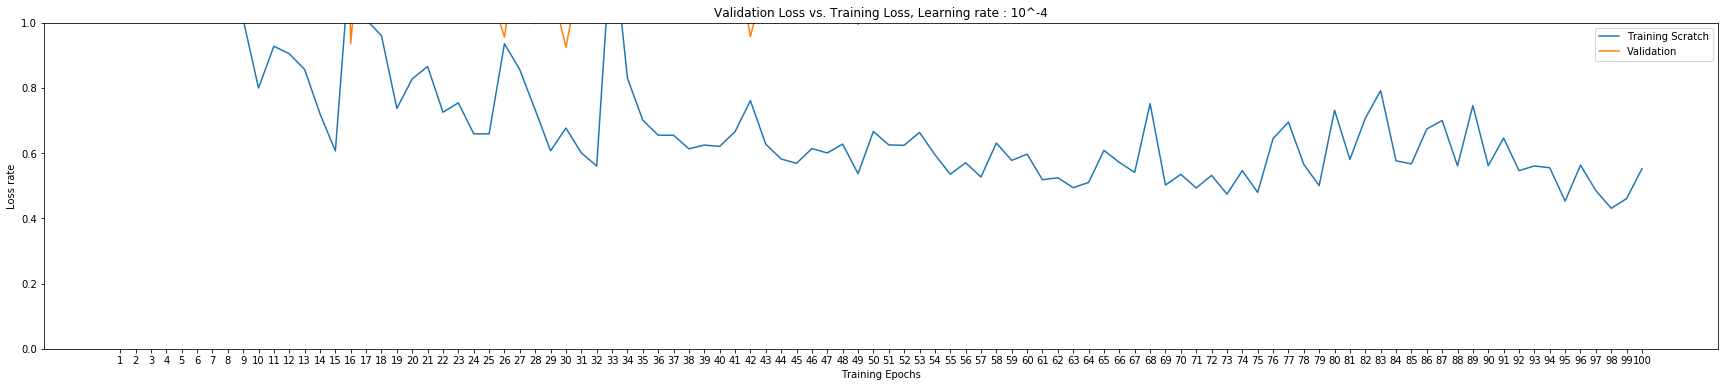

In [7]:
plt.title("Validation Loss vs. Training Loss, Learning rate : 10^-4")
plt.xlabel("Training Epochs")
plt.ylabel("Loss rate")
plt.plot(range(1,num_epochs+1),train_loss,label="Training Scratch")
plt.plot(range(1,num_epochs+1),val_loss,label="Validation")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.rcParams["figure.figsize"] = (40,6)
plt.show()